# Python для DataScience2. Курсовая работа

In [10]:
import pandas as pd
import seaborn as sns

In [11]:
!ls

2                              course_project_test.csv
3                              course_project_train.csv
4                              just_4_fun.csv
4-20191115T130905Z-001.zip     lesson_1
DGusev_predictions.csv         webinar_1.MP4
Python_in_DS2_Coursework.ipynb webinar_2.MP4
Untitled.ipynb                 webinar_3.MP4
catboost_info


Загрузим тренировочный датасет

In [12]:
data = pd.read_csv('course_project_train.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [15]:
data.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

## Очистка датасета

### Посмотрим на пустые признаки

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [5]:
[print(x) for x in data.columns];

Home Ownership
Annual Income
Years in current job
Tax Liens
Number of Open Accounts
Years of Credit History
Maximum Open Credit
Number of Credit Problems
Months since last delinquent
Bankruptcies
Purpose
Term
Current Loan Amount
Current Credit Balance
Monthly Debt
Credit Score
Credit Default


#### Home Ownership

In [63]:
data['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

По всей видимости, `Home Mortgage` и `Have Mortgage` тождественны, а значит сведем их в один признак

In [13]:
data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [14]:
data['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

#### Annual Income

In [41]:
data['Annual Income'].describe().apply("{0:.0f}".format)

count        5943
mean      1366392
std        845339
min        164597
25%        844341
50%       1168386
75%       1640137
max      10149344
Name: Annual Income, dtype: object

In [45]:
data['Annual Income'].mode()

0     969475.0
1    1043651.0
2    1058376.0
3    1161660.0
4    1338113.0
dtype: float64

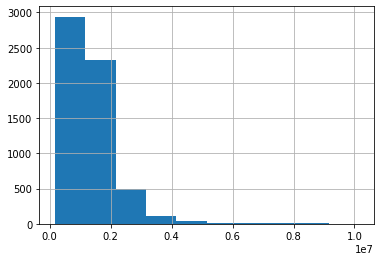

In [47]:
data['Annual Income'].hist();

#### Years in current job

In [37]:
data['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Этот признак нельзя перевести в некотигорийный.

Далее, рассмотрим долю пропущенных значений в признаке.

In [58]:
data['Years in current job'].isna().sum() / data.shape[0]

0.049466666666666666

Получается менее 5%. То есть, можно заполнить среднем или модой без сильной потери точности

In [129]:
data['Years in current job'].fillna('10+ years', inplace=True)

In [15]:
def convert_years(df):
    df['Years in current job'] = df['Years in current job'].fillna(0)
    
    for y in df['Years in current job'].unique():
        if y in [0, '< 1 year']:
            df.loc[df['Years in current job'] == y, 'Num Years in current job'] = 0
        elif y == '10+ years':
            df.loc[df['Years in current job'] == y, 'Num Years in current job'] = 20
        else:
            df.loc[df['Years in current job'] == y, 'Num Years in current job'] = int(y.split(' ')[0])
    return df.drop(columns=['Years in current job'])

In [16]:
data = convert_years(data)

#### Maximum Open Credit

In [71]:
data['Maximum Open Credit'].describe().apply("{0:.0f}".format)

count          7500
mean         945154
std        16026217
min               0
25%          279230
50%          478159
75%          793502
max      1304726170
Name: Maximum Open Credit, dtype: object

Надо посмотреть зависимость этого признака от других некатегориальных

In [103]:
data.select_dtypes(exclude='object').corr()['Maximum Open Credit']

Annual Income                   0.062218
Tax Liens                      -0.002410
Number of Open Accounts         0.023897
Years of Credit History         0.029247
Maximum Open Credit             1.000000
Number of Credit Problems      -0.004750
Months since last delinquent   -0.003849
Bankruptcies                   -0.011650
Current Loan Amount            -0.002334
Current Credit Balance          0.088090
Monthly Debt                    0.010197
Credit Score                   -0.009136
Credit Default                 -0.014275
Name: Maximum Open Credit, dtype: float64

Оставим пока как есть

#### Number of Credit Problems

In [109]:
data['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

Признак похож на нормальный, без выбросов

#### Months since last delinquent

In [112]:
data['Months since last delinquent'].isna().sum()

4081

Признак более чем на 50% пуст. Лучше пока его не брать в расчет

In [17]:
data.drop(columns=['Months since last delinquent'], inplace=True)

#### Bankruptcies

In [8]:
data['Bankruptcies'].describe()

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

заполним пустые значения нулем

In [18]:
data['Bankruptcies'].fillna(0, inplace=True)

In [19]:
data['Bankruptcies'].describe()

count    7500.000000
mean        0.116933
std         0.346904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

#### Purpose

In [20]:
data['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Пропущенных значений нет

In [21]:
# pd.get_dummies(data).columns

#### Term

In [22]:
data['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Пропущенных значений также нет

#### Current Loan Amount

In [23]:
data['Current Loan Amount'].describe().apply("{0:.0f}".format)

count        7500
mean     11873177
std      31926123
min         11242
25%        180169
50%        309573
75%        519882
max      99999999
Name: Current Loan Amount, dtype: object

Явно есть выбросы.

In [24]:
data[data['Current Loan Amount'] < 99999999.0]['Current Loan Amount'].mode()

0     89298.0
1    218064.0
dtype: float64

In [25]:
# mean_current_load_amount = data[data['Current Loan Amount'] < 99999999.0]['Current Loan Amount'].mean()

In [26]:
# data.loc[data['Current Loan Amount'] >= 99999999.0, 'Current Loan Amount'] = mean_current_load_amount

#### Current Credit Balance

In [27]:
data['Current Loan Amount'].describe().apply("{0:.0f}".format)

count        7500
mean     11873177
std      31926123
min         11242
25%        180169
50%        309573
75%        519882
max      99999999
Name: Current Loan Amount, dtype: object

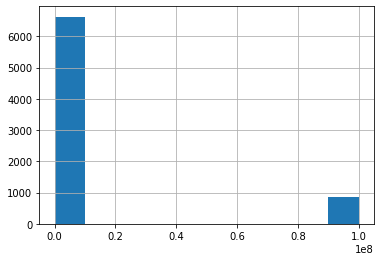

In [28]:
data['Current Loan Amount'].hist()

Явных выбросов не видно, пустых значений также нет

#### Monthly Debt

In [29]:
data['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

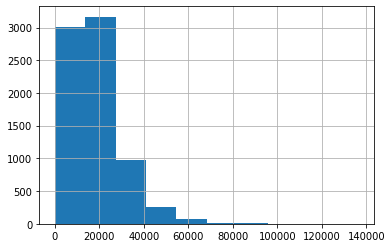

In [30]:
data['Monthly Debt'].hist()

Явных выбросов не видно, пустых значений также нет

#### Credit Score

In [31]:
data['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [32]:
data['Credit Score'].isna().sum() / 7500

0.2076

Налицо прослеживается тенденция - некоторые значения завышены ровно в 10 раз. Исправим это

In [33]:
data['Credit Score'] = data['Credit Score'].apply(lambda x: x / 10 if x // 1000 > 0 else x)

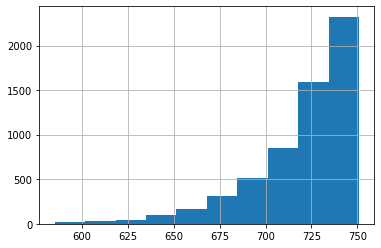

In [34]:
data['Credit Score'].hist()

In [35]:
data.dropna().corr()['Credit Score']

Annual Income                0.028571
Tax Liens                   -0.016478
Number of Open Accounts     -0.034756
Years of Credit History      0.068364
Maximum Open Credit          0.028209
Number of Credit Problems   -0.055090
Bankruptcies                -0.041420
Current Loan Amount          0.149205
Current Credit Balance      -0.005639
Monthly Debt                -0.070542
Credit Score                 1.000000
Credit Default              -0.207155
Num Years in current job    -0.013058
Name: Credit Score, dtype: float64

20% пустых значений - это много. В перспективе нужно попробовать предсказать это значение и лишь затем искать целевой класс.

Но на данном этапе заполним средним

In [30]:
data['Credit Score'].fillna(data['Credit Score'].mean(), inplace=True)

In [36]:
data['Credit Score'].fillna(0, inplace=True)

## Преобразование категориальных переменный в булевые

In [37]:
ds = pd.get_dummies(data)

Переименуем признаки - заменим пробелы и отдельные символы

In [38]:
ds.rename(lambda x: x.replace(' ','_').replace('+','more').replace('<','less'), axis='columns', inplace=True)

## Обучение и проверка

In [39]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, auc, roc_curve

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [40]:
best_model = CatBoostClassifier()

In [41]:
xgbc = XGBClassifier(colsample_bytree=0.5, gamma=0.0, 
                     learning_rate=0.005, max_depth=7, 
                     min_child_weight=0.5, n_estimators=58,
                     reg_alpha=0.9, reg_lambda=0.99,
                     subsample=0.99, seed=42, silent=1, n_jobs=-1,
                     random_state=42)

In [42]:
# Зададим распределение 
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)

In [43]:
parametrs = [{'n_estimators': [1000, 1200, 1400],
              
              'max_depth': [5, 7, 8, 9]}]

cbst = GridSearchCV(estimator=best_model,
                    param_grid=parametrs,
                   n_jobs=-1, 
                   cv=sss, 
                   scoring='f1_weighted')

In [44]:
parametrs = [{'n_estimators': [1200, 1400, 1500],
              'max_features': ["auto"],
              'max_depth': [4, 5, 7]}]

clf = GridSearchCV(estimator=xgbc, 
                   param_grid=parametrs, 
                   n_jobs=-1, 
                   cv=sss, 
                   scoring='f1_weighted')

In [45]:
X = ds.drop(columns=['Credit_Default'])
y = ds['Credit_Default']

In [122]:
cat_features = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

data = pd.read_csv('course_project_train.csv')

for i in cat_features:
    data[i] = pd.Categorical(data[i])

X = data.drop(columns=['Credit Default'])
y = data['Credit Default']

parametrs = [{'n_estimators': [1000, 1200, 1400],
              'cat_features': [cat_features],
              'max_depth': [5, 7, 8, 9]}]

cbst = GridSearchCV(estimator=best_model,
                    param_grid=parametrs,
                   n_jobs=-1, 
                   cv=sss, 
                   scoring='f1')

In [103]:
pd.Categorical(data['Purpose'])

[debt consolidation, debt consolidation, debt consolidation, debt consolidation, debt consolidation, ..., other, debt consolidation, buy a car, debt consolidation, debt consolidation]
Length: 7500
Categories (15, object): [business loan, buy a car, buy house, debt consolidation, ..., small business, take a trip, vacation, wedding]

In [91]:
print(cbst.best_params_, cbst.best_score_, '\n')

{'max_depth': 7, 'n_estimators': 1200} 0.6885186836053994 



In [181]:
X.columns

Index(['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts',
       'Years_of_Credit_History', 'Maximum_Open_Credit',
       'Number_of_Credit_Problems', 'Bankruptcies', 'Current_Loan_Amount',
       'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Score',
       'Home_Ownership_Home_Mortgage', 'Home_Ownership_Own_Home',
       'Home_Ownership_Rent', 'Years_in_current_job_1_year',
       'Years_in_current_job_10more_years', 'Years_in_current_job_2_years',
       'Years_in_current_job_3_years', 'Years_in_current_job_4_years',
       'Years_in_current_job_5_years', 'Years_in_current_job_6_years',
       'Years_in_current_job_7_years', 'Years_in_current_job_8_years',
       'Years_in_current_job_9_years', 'Years_in_current_job_less_1_year',
       'Purpose_business_loan', 'Purpose_buy_a_car', 'Purpose_buy_house',
       'Purpose_debt_consolidation', 'Purpose_educational_expenses',
       'Purpose_home_improvements', 'Purpose_major_purchase',
       'Purpose_medical_bills', 'Purpose_mo

In [159]:
X.shape

(7500, 42)

In [160]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 42 columns):
Annual_Income                        5943 non-null float64
Tax_Liens                            7500 non-null float64
Number_of_Open_Accounts              7500 non-null float64
Years_of_Credit_History              7500 non-null float64
Maximum_Open_Credit                  7500 non-null float64
Number_of_Credit_Problems            7500 non-null float64
Bankruptcies                         7500 non-null float64
Current_Loan_Amount                  7500 non-null float64
Current_Credit_Balance               7500 non-null float64
Monthly_Debt                         7500 non-null float64
Credit_Score                         7500 non-null float64
Home_Ownership_Home_Mortgage         7500 non-null uint8
Home_Ownership_Own_Home              7500 non-null uint8
Home_Ownership_Rent                  7500 non-null uint8
Years_in_current_job_1_year          7500 non-null uint8
Years_in_current

In [46]:
X.columns

Index(['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts',
       'Years_of_Credit_History', 'Maximum_Open_Credit',
       'Number_of_Credit_Problems', 'Bankruptcies', 'Current_Loan_Amount',
       'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Score',
       'Num_Years_in_current_job', 'Home_Ownership_Home_Mortgage',
       'Home_Ownership_Own_Home', 'Home_Ownership_Rent',
       'Purpose_business_loan', 'Purpose_buy_a_car', 'Purpose_buy_house',
       'Purpose_debt_consolidation', 'Purpose_educational_expenses',
       'Purpose_home_improvements', 'Purpose_major_purchase',
       'Purpose_medical_bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable_energy', 'Purpose_small_business',
       'Purpose_take_a_trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long_Term', 'Term_Short_Term'],
      dtype='object')

In [47]:
clf.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0.0,
                                     learning_rate=0.005, max_delta_step=0,
                                     max_depth=7, min_child_weight=0.5,
                                     missing=None, n_estimato...
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0.9,
                                     reg_lambda=0.99, scale_pos_weight=1,
                                     seed=42, silent=1, subsample=0.99,
                                     verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid=[

In [48]:
print(clf.best_params_, clf.best_score_, '\n')

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1400} 0.6752195319044757 



In [162]:
print(clf.best_params_, clf.best_score_, '\n')

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1400} 0.6727598709325842 



In [164]:
X['Credit_Score']

0       749.0
1       737.0
2       742.0
3       694.0
4       719.0
        ...  
7495    697.0
7496    741.0
7497    748.0
7498      0.0
7499      0.0
Name: Credit_Score, Length: 7500, dtype: float64

In [49]:
test = pd.read_csv('course_project_test.csv')

In [50]:
def prapair_dataset(data):
    data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    data['Years in current job'].fillna('10+ years', inplace=True)
    data['Bankruptcies'].fillna(0, inplace=True)
    
    data.drop(columns=['Months since last delinquent'], inplace=True)
    
    data['Annual Income'].fillna(data['Annual Income'].mode()[0], inplace=True)
    
    mean_current_load_amount = data[data['Current Loan Amount'] < 99999999.0]['Current Loan Amount'].mean()
#     data.loc[data['Current Loan Amount'] >= 99999999.0, 'Current Loan Amount'] = mean_current_load_amount
    
    data = convert_years(data)
    
    data['Credit Score'] = data['Credit Score'].apply(lambda x: x / 10 if x // 1000 > 0 else x)
#     data['Credit Score'].fillna(data['Credit Score'].mean(), inplace=True)
    data['Credit Score'].fillna(0, inplace=True)
    ds = pd.get_dummies(data)
    ds.rename(lambda x: x.replace(' ','_').replace('+','more').replace('<','less'), axis='columns', inplace=True)
    return ds

In [51]:
test_prepaired = prapair_dataset(test)

In [54]:
test_prepaired['Purpose_renewable_energy'] = 0

In [55]:
answer = pd.DataFrame(range(7500, 10000), columns=['Id'])

In [56]:
answer['Credit Default'] = clf.predict(test_prepaired[X.columns]).astype('int')

In [57]:
answer

,Id,Credit Default
0,7500,0
1,7501,0
2,7502,0
3,7503,0
4,7504,0
...,...,...
2495,9995,0
2496,9996,0
2497,9997,0
2498,9998,0


In [58]:
answer.to_csv('DGusev_predictions.csv',index=None)